**In this notebook, I will apply In-context learning (ICL) to the SemEval 2016 dataset for the task of stance detection.**

In-context learning (ICL) is a paradigm that enables language models to learn new tasks by being provided with only a few demonstrator examples.
The language model utilized here is Llama 3.1 with 8B parameters. Llama 3.1 is a free open-source AI model from Meta. The Llama 3.1 model was run using Ollama, which is a framework for building and running language models on the local machine.

Ollama allows users to customize the system prompt of the AI model. A system prompt is a set of overarching instructions that define how the AI model whould behave across all interactions. The system prompt of the Llama 3.1 model was customized with instructions, rules, and examples to suit my use case (climate change stance detection). The instructions were written by me following other research papers, while the rules and examples were generated by the Llama 3.1 model.

The user prompt is a specific, task-oriented instruction or query that you give to an AI system for a particular interaction. The user prompt utilized for this task is: 

*prompt = (
        "You are an expert in climate change tweets stance classification. Using the rules and examples as a guide, label only the unlabeled tweet. You must only respond with only one of the labels: 'favor', 'against', or 'none'. Do not return any blank response."
    )*

Note: Here I will not be using the oversampled data subsets because it makes no difference in the ICL performance, since I am using k-nearest neighbors (KNN) to pick the demonstrators. 

The KNN algorithm is a simple, supervised machine learning method that makes predictions based on how close a data point is to others. KNN will pick examples based on how similar the embedddings are. The embeddings for KNN will be generated using BERTweet. BERTweet is the first public large-scale pre-trained language model for English Tweets.

This model will select 5 KNN examples for each tweet in the test data, from whatever subset (10% to 100%) of the training data is available. It will then use those examples to predict a label for each tweet in the test data.


[Reference 1: Ollama](https://ollama.com)

[Reference 2: Meta](https://www.llama.com)

[Reference 3: User prompt vs System prompt](https://www.regie.ai/blog/user-prompts-vs-system-prompts)

[Reference 4: KNN](https://www.analyticsvidhya.com/blog/2018/03/introduction-k-neighbours-algorithm-clustering/)

[Reference 5: BERTweet](https://arxiv.org/pdf/2005.10200)

[Reference 6: SemEval-2106 Stance Dataset](https://www.saifmohammad.com/WebPages/StanceDataset.htm)

In [23]:
# Load libraries

import os
import glob
import re
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import f1_score, classification_report
from scipy.spatial.distance import cosine
from transformers import AutoTokenizer, AutoModel

import ollama
from tqdm import tqdm
from sklearn.metrics import f1_score



In [24]:
# LOAD TEST DATA (CONSTANT)
DATA_PATH = "semeval_data"


test_path = os.path.join(DATA_PATH, "cleaned_test.csv")
test_df = pd.read_csv(test_path).reset_index(drop=True)

# Convert to lowercase for easier metric comparisons
test_df["Stance"] = test_df["Stance"].str.lower()

print("Loaded test_df.csv:", test_df.shape)
print(test_df["Stance"].value_counts())


Loaded test_df.csv: (169, 2)
Stance
favor      123
none        35
against     11
Name: count, dtype: int64


In [25]:
# LOAD MODEL 

# Specify model
model_name = "vinai/bertweet-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [26]:
# Preprocessing Tweets

def preprocess(text):
    # Check if text is a valid non-empty string
    if not isinstance(text, str) or text.strip() == '':
        return ''
    
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t

        # Skip tokens that start with a hashtag
        #if t.startswith('#'):
          #  continue
            
        new_text.append(t)
    return " ".join(new_text).lower()

# Batch encoding with embeddings
def batch_encode(model, tokenizer, texts, max_length=128):
    preprocessed_texts = [preprocess(t) for t in texts]
    encoded_inputs = tokenizer(
        preprocessed_texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_length
    )
    with torch.no_grad():
        outputs = model(**encoded_inputs)
        features = outputs[0].mean(dim=1).cpu().numpy()
    return features


In [28]:
# Function to find KNN using embeddings
def get_similarities_representative(
    test_embedding, 
    train_embeddings, 
    train_df, 
    k=5
):
    """
    Given a single test embedding, find k most similar items in 'train_embeddings',
    ensuring at least one example per label if possible.
    """
    # Cosine similarities
    sims = [1 - cosine(test_embedding, emb) for emb in train_embeddings]
    sims = np.array(sims)

    # Indices of all training examples
    all_indices = np.arange(len(train_df))
    train_labels = train_df["Stance"].values

    # 1) pick the top example for each label (if it exists)
    unique_labels = ["favor", "against", "none"]
    selected_indices = set()
    for label in unique_labels:
        label_mask = (train_labels == label)
        label_indices = all_indices[label_mask]
        if len(label_indices) > 0:
            # pick the single highest similarity in that label
            label_sims = sims[label_indices]
            max_in_label = label_indices[np.argmax(label_sims)]
            selected_indices.add(max_in_label)

    # 2) Fill the remaining slots purely by highest similarity
    num_selected = len(selected_indices)
    remain_needed = k - num_selected
    if remain_needed > 0:
        remaining_indices = np.setdiff1d(all_indices, list(selected_indices))
        remain_sims = sims[remaining_indices]
        # sort descending by sim
        top_remain = remaining_indices[np.argsort(-remain_sims)[:remain_needed]]
        for idx in top_remain:
            selected_indices.add(idx)

    # sort final selected by descending similarity
    selected_list = list(selected_indices)
    selected_list = sorted(selected_list, key=lambda idx: -sims[idx])

    # return the corresponding train_df rows
    return train_df.iloc[selected_list].copy()

In [29]:
def ollama_label(in_context_examples, test_row, client, model_name):
    """
    Classify the stance of a climate change tweet using a language model, a set of examples and predefined rules.
    
    Args:
        test_row: A row from test_df containing the tweet information.
        client: The language model client.
        model_name: The name of the language model to use.
        
    Returns:
        str: The predicted label for the test_row.
    """


    # User prompt
    prompt = (
        "You are an expert in climate change tweets stance classification. "
        "Using the rules and examples as a guide, label only the unlabeled tweet. You must only respond with only one of the labels: 'favor', 'against', or 'none'. "
        "Do not return any blank response.\n\n"
    )

    # Preprocess the tweet text
    tweet_text = preprocess(test_row.get('Tweet', ''))



    # Append in-context examples to the instruction
    for _, row in in_context_examples.iterrows():
            stance_lower = str(row["Stance"]).lower()
            example_text = (
                f'Tweet: "{row["Tweet"]}"\n'
                f'Label: {stance_lower}\n\n'
            )
            prompt += example_text
        
    # Construct the test tweet part of the prompt
    test_tweet_text = (
        f'Tweet: "{test_row["Tweet"]}"\n'
        f'Label: '
    )
    prompt += test_tweet_text

    

    # Generate output from the model
    response = client.generate(model=model_name, prompt=prompt)

    # Extract the generated label
    generated_label = response.response.strip().lower()

    return generated_label




==== Now Running LLaMA ICL on subset_train_10.csv ====


Classifying subset_train_10.csv: 100%|████████████| 6/6 [01:18<00:00, 13.12s/it]


Done with subset_train_10.csv  => {'macro_f1': 0.6458405922013778, 'f1_against': 0.5555555555555556, 'f1_favor': 0.8036529680365296, 'f1_none': 0.5783132530120482, 'f_avg': 0.6796042617960426}

==== Now Running LLaMA ICL on subset_train_100.csv ====


Classifying subset_train_100.csv: 100%|███████████| 6/6 [01:59<00:00, 19.99s/it]


Done with subset_train_100.csv  => {'macro_f1': 0.6303850478886347, 'f1_against': 0.47058823529411764, 'f1_favor': 0.8108108108108109, 'f1_none': 0.6097560975609756, 'f_avg': 0.6406995230524642}

==== Now Running LLaMA ICL on subset_train_20.csv ====


Classifying subset_train_20.csv: 100%|████████████| 6/6 [01:39<00:00, 16.55s/it]


Done with subset_train_20.csv  => {'macro_f1': 0.6276477146042363, 'f1_against': 0.5641025641025641, 'f1_favor': 0.7536231884057971, 'f1_none': 0.5652173913043478, 'f_avg': 0.6588628762541806}

==== Now Running LLaMA ICL on subset_train_30.csv ====


Classifying subset_train_30.csv: 100%|████████████| 6/6 [01:32<00:00, 15.49s/it]


Done with subset_train_30.csv  => {'macro_f1': 0.6380509934785927, 'f1_against': 0.5882352941176471, 'f1_favor': 0.7741935483870968, 'f1_none': 0.5517241379310345, 'f_avg': 0.6812144212523719}

==== Now Running LLaMA ICL on subset_train_40.csv ====


Classifying subset_train_40.csv: 100%|████████████| 6/6 [01:31<00:00, 15.21s/it]


Done with subset_train_40.csv  => {'macro_f1': 0.6429622181256168, 'f1_against': 0.5555555555555556, 'f1_favor': 0.8054298642533937, 'f1_none': 0.5679012345679012, 'f_avg': 0.6804927099044746}

==== Now Running LLaMA ICL on subset_train_50.csv ====


Classifying subset_train_50.csv: 100%|████████████| 6/6 [01:30<00:00, 15.16s/it]


Done with subset_train_50.csv  => {'macro_f1': 0.6841288166589372, 'f1_against': 0.6060606060606061, 'f1_favor': 0.8198198198198198, 'f1_none': 0.6265060240963856, 'f_avg': 0.7129402129402129}

==== Now Running LLaMA ICL on subset_train_60.csv ====


Classifying subset_train_60.csv: 100%|████████████| 6/6 [01:29<00:00, 14.88s/it]


Done with subset_train_60.csv  => {'macro_f1': 0.656017717166419, 'f1_against': 0.5161290322580645, 'f1_favor': 0.8177777777777778, 'f1_none': 0.6341463414634146, 'f_avg': 0.6669534050179211}

==== Now Running LLaMA ICL on subset_train_70.csv ====


Classifying subset_train_70.csv: 100%|████████████| 6/6 [01:31<00:00, 15.33s/it]


Done with subset_train_70.csv  => {'macro_f1': 0.6584128320239432, 'f1_against': 0.5454545454545454, 'f1_favor': 0.8125, 'f1_none': 0.6172839506172839, 'f_avg': 0.6789772727272727}

==== Now Running LLaMA ICL on subset_train_80.csv ====


Classifying subset_train_80.csv: 100%|████████████| 6/6 [01:35<00:00, 15.90s/it]


Done with subset_train_80.csv  => {'macro_f1': 0.6625396825396827, 'f1_against': 0.5142857142857142, 'f1_favor': 0.8333333333333334, 'f1_none': 0.64, 'f_avg': 0.6738095238095239}

==== Now Running LLaMA ICL on subset_train_90.csv ====


Classifying subset_train_90.csv: 100%|████████████| 6/6 [01:32<00:00, 15.44s/it]

Done with subset_train_90.csv  => {'macro_f1': 0.6309309309309309, 'f1_against': 0.5, 'f1_favor': 0.7927927927927928, 'f1_none': 0.6, 'f_avg': 0.6463963963963963}


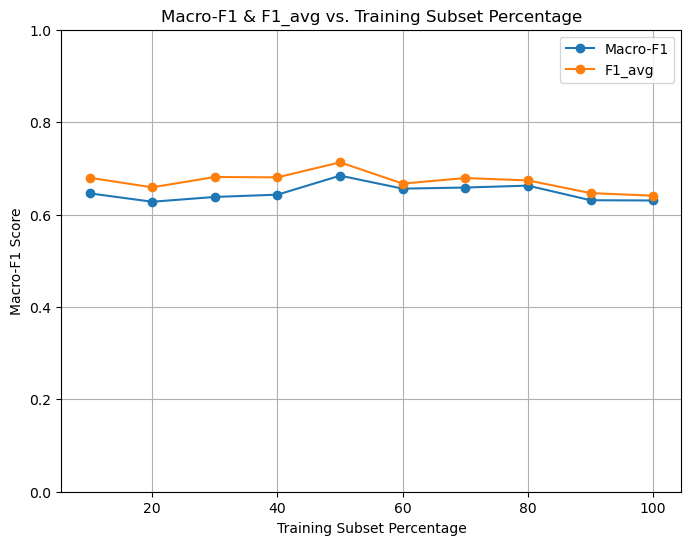


=== Final Results Summary ===
subset_train_10.csv => Macro-F1=0.646, F1(AGAINST)=0.556, F1(FAVOR)=0.804, F1(NONE)=0.578,F1(AVG)=0.680
subset_train_20.csv => Macro-F1=0.628, F1(AGAINST)=0.564, F1(FAVOR)=0.754, F1(NONE)=0.565,F1(AVG)=0.659
subset_train_30.csv => Macro-F1=0.638, F1(AGAINST)=0.588, F1(FAVOR)=0.774, F1(NONE)=0.552,F1(AVG)=0.681
subset_train_40.csv => Macro-F1=0.643, F1(AGAINST)=0.556, F1(FAVOR)=0.805, F1(NONE)=0.568,F1(AVG)=0.680
subset_train_50.csv => Macro-F1=0.684, F1(AGAINST)=0.606, F1(FAVOR)=0.820, F1(NONE)=0.627,F1(AVG)=0.713
subset_train_60.csv => Macro-F1=0.656, F1(AGAINST)=0.516, F1(FAVOR)=0.818, F1(NONE)=0.634,F1(AVG)=0.667
subset_train_70.csv => Macro-F1=0.658, F1(AGAINST)=0.545, F1(FAVOR)=0.812, F1(NONE)=0.617,F1(AVG)=0.679
subset_train_80.csv => Macro-F1=0.663, F1(AGAINST)=0.514, F1(FAVOR)=0.833, F1(NONE)=0.640,F1(AVG)=0.674
subset_train_90.csv => Macro-F1=0.631, F1(AGAINST)=0.500, F1(FAVOR)=0.793, F1(NONE)=0.600,F1(AVG)=0.646
subset_train_100.csv => Macro-F1=

In [30]:
# RUN OVER ALL SPLITS AND PLOT RESULT

client = ollama.Client()
model_name = "UwailaE/stanceGeneral3.1v2"
batch_size = 32

DATA_PATH = "semeval_data/initial_splits"

subset_paths = sorted(glob.glob(os.path.join(DATA_PATH, "subset_train_*.csv")))  #path to train data

results = []

def run_llama_on_subset(subset_path, test_df, client, model_name, k=5, batch_size=32):
    """
    1) Load subset_train_X.csv
    2) Embed it
    3) Embed test data
    4) For each test sample (in batches of batch_size), find top-k neighbors
       and classify with LLaMA (ollama_label).
    5) Compute macro-F1, F_avg and per-label F1
    6) Return results as a dict
    """
    # 1) Load subset training data
    train_df = pd.read_csv(subset_path).reset_index(drop=True)
    # Standardize stance column to lower
    train_df["Stance"] = train_df["Stance"].str.lower()

    # 2) Embed training data
    train_texts = train_df["Tweet"].tolist()
    train_embeddings = batch_encode(model, tokenizer, train_texts)

    # 3) Embed test data
    test_texts = test_df["Tweet"].tolist()
    test_embeddings = batch_encode(model, tokenizer, test_texts)

    # 4) Classify in batches
    predictions = [None] * len(test_df)
    n_test = len(test_df)

    for start_idx in tqdm(range(0, n_test, batch_size), 
                          desc=f"Classifying {os.path.basename(subset_path)}", 
                          total=(n_test - 1)//batch_size + 1):
        end_idx = min(start_idx + batch_size, n_test)
        batch_rows = test_df.iloc[start_idx:end_idx]
        batch_embs = test_embeddings[start_idx:end_idx]
        
        # For each sample in the batch
        in_context_examples_batch = []
        for emb in batch_embs:
            # find top-k neighbors for each sample
            top_k_df = get_similarities_representative(
                test_embedding=emb,
                train_embeddings=train_embeddings,
                train_df=train_df,
                k=k
            )
            in_context_examples_batch.append(top_k_df)
        
        # Now generate labels for this batch
        for i, (idx, row) in enumerate(batch_rows.iterrows()):
            examples = in_context_examples_batch[i]
            predicted_label = ollama_label(
                in_context_examples=examples,
                test_row=row,
                client=client,
                model_name=model_name
            )
            predictions[idx] = predicted_label.strip()

    # 5) Compute metrics
    true_labels = test_df["Stance"].tolist() 
    pred_labels = [p for p in predictions]

    stance_labels = ["against", "favor", "none"]
    macro_f1 = f1_score(true_labels, pred_labels, average="macro", labels=stance_labels)
    per_label_f1_arr = f1_score(true_labels, pred_labels, average=None, labels=stance_labels)

    f1_against = per_label_f1_arr[0]
    f1_favor   = per_label_f1_arr[1]
    f1_none    = per_label_f1_arr[2]

    # Compute the average F1 for "against" and "favor"
    f_avg = (f1_against + f1_favor) / 2

    results_dict = {
        "macro_f1": macro_f1,
        "f1_against": f1_against,
        "f1_favor":   f1_favor,
        "f1_none":    f1_none,
        "f_avg": f_avg  
    }
    return results_dict


# MAIN LOOP OVER SPLITS 
for path in subset_paths:
    # parse fraction from filename
    basename = os.path.basename(path) 
    match = re.search(r"(\d+)\.csv", basename)
    fraction_val = None
    if match:
        fraction_val = int(match.group(1))
    
    print(f"\n==== Now Running LLaMA ICL on {basename} ====")
    subset_result = run_llama_on_subset(
        subset_path=path, 
        test_df=test_df, 
        client=client, 
        model_name=model_name, 
        k=5,
        batch_size=batch_size
    )
    
    # store in results
    results.append({
        "filename": basename,
        "frac_val": fraction_val,
        "macro_f1": subset_result["macro_f1"],
        "f1_against": subset_result["f1_against"],
        "f1_favor":   subset_result["f1_favor"],
        "f1_none":    subset_result["f1_none"],
        "f_avg": subset_result["f_avg"] 
    })

    print("Done with", basename, " =>", subset_result)

# Sort results by fraction
results_sorted = sorted(results, key=lambda x: x["frac_val"] if x["frac_val"] else 999)

# Now plot
fractions = [r["frac_val"] for r in results_sorted]
macro_f1s = [r["macro_f1"] for r in results_sorted]
f1_against = [r["f1_against"] for r in results_sorted]
f1_favor   = [r["f1_favor"] for r in results_sorted]
f1_none    = [r["f1_none"] for r in results_sorted]
f1_avg     = [r["f_avg"] for r in results_sorted]

plt.figure(figsize=(8,6))
plt.plot(fractions, macro_f1s, marker='o', label='Macro-F1')
plt.plot(fractions, f1_avg, marker='o', label='F1_avg')
plt.title("Macro-F1 & F1_avg vs. Training Subset Percentage")
plt.xlabel("Training Subset Percentage")
plt.ylabel("F1 Score")
plt.ylim([0,1])
plt.grid(True)
plt.legend()
plt.show()

# plt.figure(figsize=(8,6))
# plt.plot(fractions, f1_against, marker='o', label='F1 AGAINST')
# plt.plot(fractions, f1_favor,   marker='o', label='F1 FAVOR')
# plt.plot(fractions, f1_none,    marker='o', label='F1 NONE')
# plt.title("Per-label F1 vs. Training Fraction (%) - LLaMA ICL")
# plt.xlabel("Training Data Percentage")
# plt.ylabel("F1 Score")
# plt.ylim([0,1])
# plt.grid(True)
# plt.legend()
# plt.show()

print("\n=== Final Results Summary ===")
for r in results_sorted:
    print(
        f"{r['filename']} => Macro-F1={r['macro_f1']:.3f}, "
        f"F1(AGAINST)={r['f1_against']:.3f}, "
        f"F1(FAVOR)={r['f1_favor']:.3f}, "
        f"F1(NONE)={r['f1_none']:.3f},"
        f"F1(AVG)={r['f_avg']:.3f}"
    )


In [31]:
# Convert to DataFrame
icl_df = pd.DataFrame(results_sorted)

# Add a column indicating the approach
icl_df["approach"] = "ICL"

# Save to CSV
icl_df.to_csv("semeval_data/icl_results.csv", index=False)
print("Saved ICL results to icl_results.csv!")

Saved ICL results to icl_results.csv!
